Tutorial based on: https://aws.amazon.com/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/ and https://github.com/aldente0630/sound-anomaly-detection-with-autoencoders/

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load neccessary libraries
import os
import warnings
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from utils.misc import download_and_unzip_file
from utils.sound_utils import load_sound_file

In [7]:
warnings.filterwarnings("ignore")
plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

The MIMII dataset can be downloaded from [this website](https://zenodo.org/record/3384388). The dataset includes sounds from various types of industrial machinery (valve, pump, fan and slide rail). In this modeling, I will only focus on the fans. These files are approximately 14 GB if uncompressed.

In [8]:
DATA_PATH = "../../data/mimii-anomaly-detection"
IMAGE_PATH = "./img"
FILE_NAMES = [
    "-6_dB_fan",
    "-6_dB_valve",
    "-6_dB_pump",
    "-6_dB_slider",
    "6_dB_fan",
    "6_dB_valve",
    "6_dB_pump",
    "6_dB_slider",
    "0_dB_fan",
    "0_dB_pump",
    "0_dB_valve",
    "0_dB_slider",
]

file_names = [FILE_NAMES[4]]  # only the fans
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

for file_name in file_names:
    download_and_unzip_file(DATA_PATH, file_name)

Sound files found, no need to download them again.


# Exploratory Data Analysis
The recording file for each mechanical equipment contains a total of 8 channels, one for each microphone used to record sound. The rest of this experiment focuses on what was recorded with the first microphone. Let"s do an EDA by selecting a pair of normal and abnormal 10-second sound wave files.

In [9]:
normal_signal_file = os.path.join(
    DATA_PATH, "6dB", "fan", "id_00", "normal", "00000101.wav"
)  # only one pair of sound clips selected
abnormal_signal_file = os.path.join(
    DATA_PATH, "6dB", "fan", "id_00", "abnormal", "00000101.wav"
)
normal_signal, _ = load_sound_file(normal_signal_file)
abnormal_signal, sr = load_sound_file(abnormal_signal_file)

print(
    f"The signals have a {normal_signal.shape} shape. At {sr} Hz, these are {normal_signal.shape[0] / sr:.0f}s signals."
)

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals.


In [6]:
# https://ipython.org/ipython-doc/3/api/generated/IPython.display.html
IPython.display.Audio(normal_signal_file, rate=sr)

In [7]:
IPython.display.Audio(abnormal_signal_file, rate=sr)

### Wave Forms

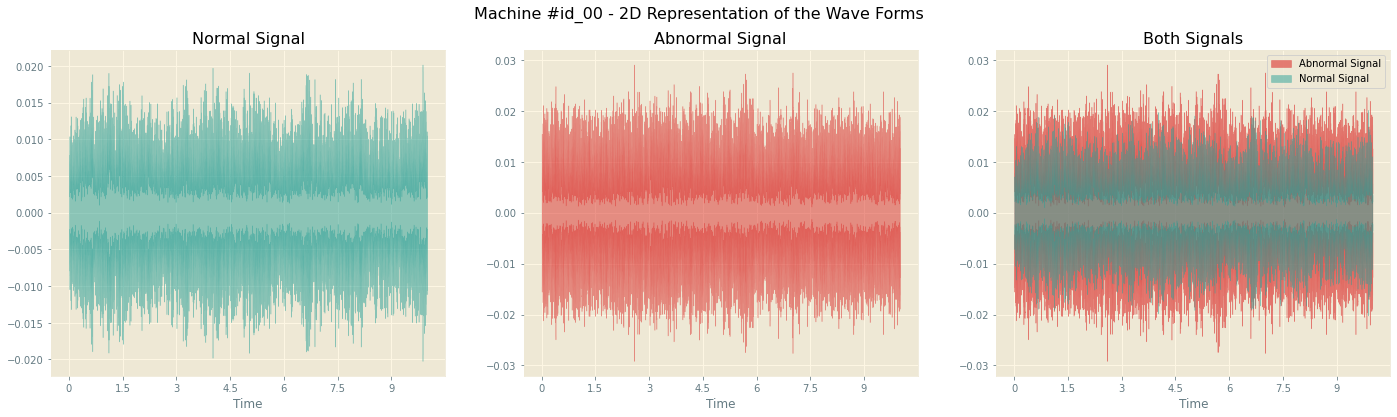

In [20]:
import librosa.display
fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
# Visualize a waveform in the time domain.
librosa.display.waveshow(
    # audio time series (mono or stereo)
    normal_signal,
    # sampling rate of y (samples per second)
    sr=sr,
    # color intensity
    alpha=0.5,
    color=colors[1],
    linewidth=0.5,
    label="Machine #id_00 - Normal Signal",
)
plt.title("Normal Signal")

plt.subplot(1, 3, 2)
librosa.display.waveshow(
    abnormal_signal,
    sr=sr,
    alpha=0.5,
    color=colors[5],
    linewidth=0.5,
    label="Machine #id_00 - Abnormal Signal",
)
plt.title("Abnormal Signal")

plt.subplot(1, 3, 3)
librosa.display.waveshow(
    abnormal_signal,
    sr=sr,
    alpha=0.6,
    color=colors[5],
    linewidth=0.5,
    label="Abnormal Signal",
)
librosa.display.waveshow(
    normal_signal,
    sr=sr,
    alpha=0.5,
    color=colors[1],
    linewidth=0.5,
    label="Normal Signal",
)
plt.title("Both Signals")

fig.suptitle("Machine #id_00 - 2D Representation of the Wave Forms", fontsize=16)
plt.legend()
plt.show()
#fig.savefig(os.path.join(IMAGE_PATH, "wave_forms.svg"), format="svg")

### Short Time Fourier Tranform
Short-time Fourier transform (STFT) is a sequence of Fourier transforms of a windowed signal. STFT provides the time-localized frequency information for situations in which frequency components of a signal vary over time, whereas the standard Fourier transform provides the frequency information averaged over the entire signal time interval.

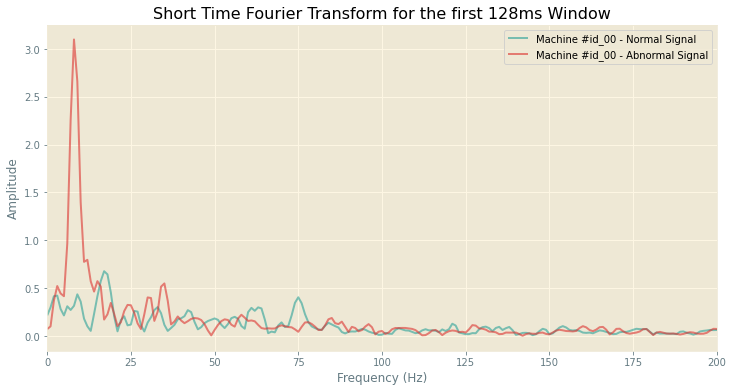

In [8]:
n_fft = 2048
# https://librosa.org/doc/main/generated/librosa.stft.html
normal_stft = np.abs(
    librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1)
)
abnormal_stft = np.abs(
    librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1)
)

fig = plt.figure(figsize=(12, 6))
plt.plot(
    normal_stft, color=colors[1], alpha=0.6, label="Machine #id_00 - Normal Signal"
)
plt.plot(
    abnormal_stft, color=colors[5], alpha=0.6, label="Machine #id_00 - Abnormal Signal"
)
plt.title(
    f"Short Time Fourier Transform for the first {n_fft / sr * 1000:.0f}ms Window"
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(0, 200)
plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "stft.svg"), format="svg")

### Spectrograms (dB scale)
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

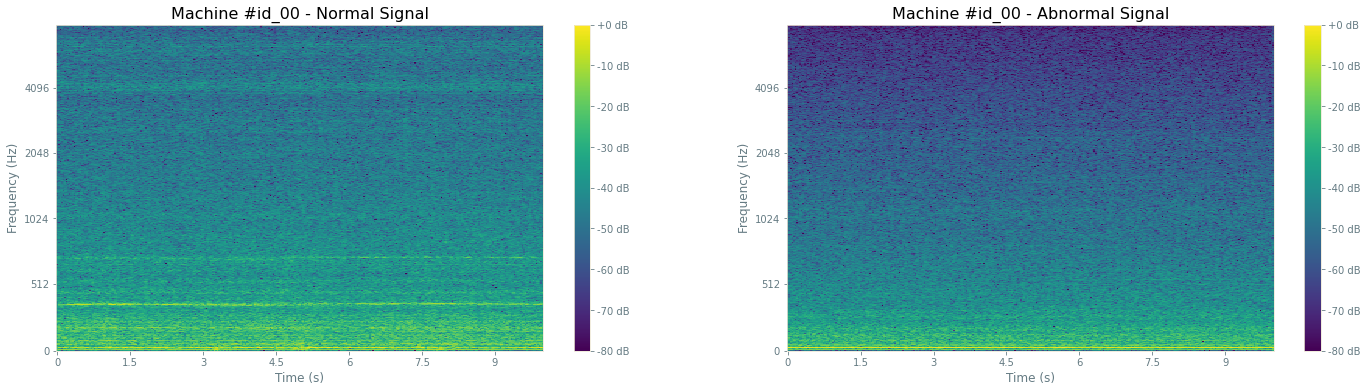

The spectrograms have a (1025, 313) shape.


In [9]:
hop_length = 512
normal_stft = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
normal_spectrogram = librosa.amplitude_to_db(normal_stft, ref=np.max)
abnormal_stft = np.abs(
    librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length)
)
abnormal_spectrogram = librosa.amplitude_to_db(abnormal_stft, ref=np.max)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(
    normal_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis"
)
plt.title("Machine #id_00 - Normal Signal")
plt.colorbar(format="%+2.f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.subplot(1, 2, 2)
librosa.display.specshow(
    abnormal_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis"
)
plt.title("Machine #id_00 - Abnormal Signal")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "spectrograms.svg"), format="svg")

print(f"The spectrograms have a {normal_spectrogram.shape} shape.")

### Mel-Spectrograms
https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0 <br>
https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

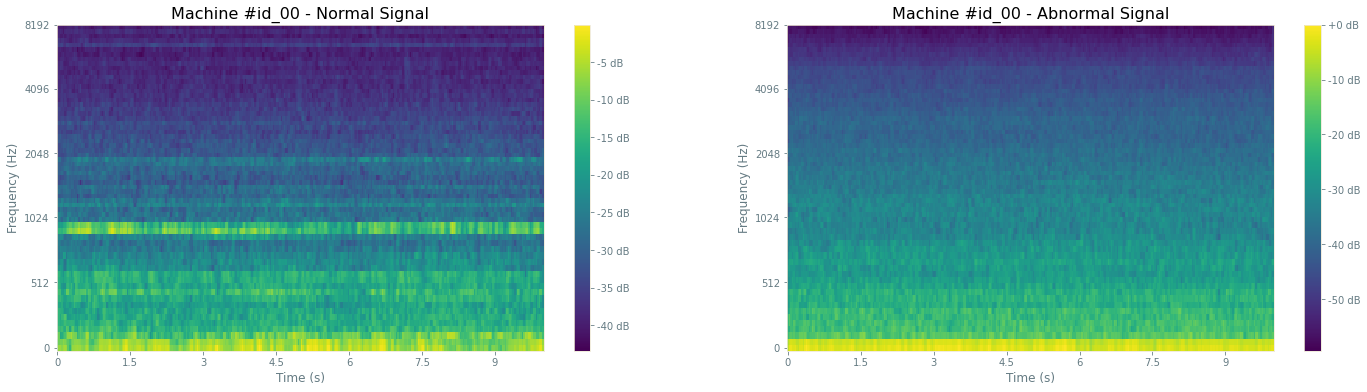

The mel-spectrograms have a (64, 313) shape.


In [10]:
n_mels = 64
normal_mel_spectrogram = librosa.feature.melspectrogram(
    normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
normal_mel_spectrogram = librosa.power_to_db(normal_mel_spectrogram, ref=np.max)
abnormal_mel_spectrogram = librosa.feature.melspectrogram(
    abnormal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
abnormal_mel_spectrogram = librosa.power_to_db(abnormal_mel_spectrogram, ref=np.max)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(
    normal_mel_spectrogram,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
)
plt.title("Machine #id_00 - Normal Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 2, 2)
librosa.display.specshow(
    abnormal_mel_spectrogram,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
)
plt.title("Machine #id_00 - Abnormal Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")

plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "mel_spectrograms.svg"), format="svg")

print(f"The mel-spectrograms have a {normal_mel_spectrogram.shape} shape.")

### Multiple Frames of Spectrograms

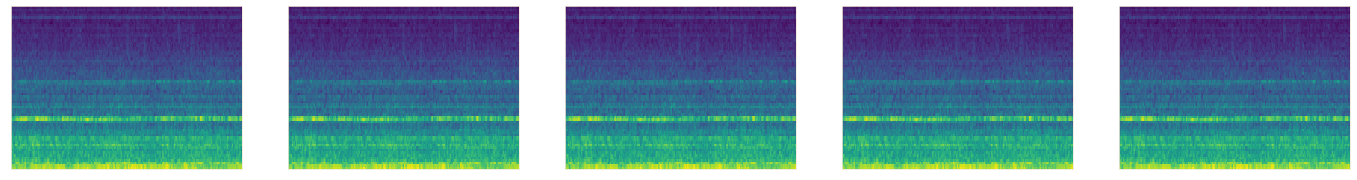

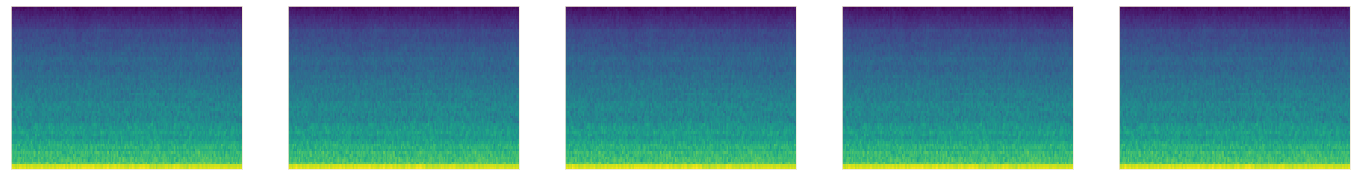

The features have a (309, 320) shape.


In [11]:
frames = 5
dims = frames * n_mels

features_vector_size = normal_mel_spectrogram.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t : n_mels * (t + 1)] = normal_mel_spectrogram[
        :, t : t + features_vector_size
    ].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(
        features[:, n_mels * t : n_mels * (t + 1)].T,
        sr=sr,
        hop_length=hop_length,
        cmap="viridis",
    )
fig.savefig(os.path.join(IMAGE_PATH, "normal_frames.svg"), format="svg")

features_vector_size = abnormal_mel_spectrogram.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t : n_mels * (t + 1)] = abnormal_mel_spectrogram[
        :, t : t + features_vector_size
    ].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(
        features[:, n_mels * t : n_mels * (t + 1)].T,
        sr=sr,
        hop_length=hop_length,
        cmap="viridis",
    )

plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "abnormal_frames.svg"), format="svg")

print(f"The features have a {features.shape} shape.")